In [2]:
# Importar librerias necesarias
import sys
import os
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import logging

# Importar librerias custom
from config import Config
from database.connection import DatabaseManager
from utils.data_processing import DataProcessor, RainfallProcessor

# Configurar Logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Suprimir las advertencias para obtener un resultado más limpio
warnings.filterwarnings('ignore')

# Establecer estilo de trazado
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("="*60)
print("WATER MANAGEMENT AI - DATA INTEGRATION")
print("="*60)
print("Notebook 01: Temporal Fusion of Rainfall and Consumption Data")
print("Author: Luis Pillaga")
print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)

WATER MANAGEMENT AI - DATA INTEGRATION
Notebook 01: Temporal Fusion of Rainfall and Consumption Data
Author: Luis Pillaga
Date: 2025-05-25 12:33:19


In [3]:
# 1. Configuración inicial

# Cargar configuración
config = Config()
print(f"✅ Configuración Cargada Correctemente")
print(f"📊 Nombre de la BD: {config.DB_NAME}")
print(f"📁 PATH CSV: {config.RAINFALL_DATA_PATH}")
print(f"💾 PATH Salida: {config.PROCESSED_DATA_PATH}")

✅ Configuración Cargada Correctemente
📊 Nombre de la BD: junta_jeru_backend
📁 PATH CSV: ./data/raw/rainfall_ecuador.csv
💾 PATH Salida: ./data/processed/


In [4]:
# 2. Conexión con la BD y exploración inicial

try:
    db_manager = DatabaseManager(config)
    print("✅ Conexión establecida a la BD")
except Exception as e:
    print(f"❌ A ocurrido un error conectado a la BD: {e}")
    raise

INFO:database.connection:Database connection established successfully


✅ Conexión establecida a la BD


In [5]:
# 2.1 Explorar estructura de datos inicial

# Obtener estadisticas básicas de la BD
print("\n🔍 Exploración en la BD")
print("-" * 40)

# Resumen de Medidores
water_meters_df = db_manager.get_water_meters_data()
print(f"📊 Total medidores: {len(water_meters_df)}")
print(f"📊 Medidores activos: {len(water_meters_df[water_meters_df['meter_status'] == 1])}")

# Resumen de Barrios
neighborhoods = water_meters_df['neighborhood_name'].value_counts()
print(f"🏘️  Barrios: {len(neighborhoods)}")
print("Top 5 Barrios por Cantidad de Medidores:")
for neighborhood, count in neighborhoods.head().items():
    print(f"  • {neighborhood}: {count} medidores")


🔍 Exploración en la BD
----------------------------------------
📊 Total medidores: 355
📊 Medidores activos: 355
🏘️  Barrios: 7
Top 5 Barrios por Cantidad de Medidores:
  • Centro: 75 medidores
  • El Progreso: 59 medidores
  • Tres Esquinas: 58 medidores
  • Jerusalen bajo: 53 medidores
  • La Loma: 44 medidores


In [6]:
# 2.2 Cargar Datos de Consumo

print("\n📈 CARGANDO DATOS DE CONSUMO")
print("-" * 40)

# Obtener datos de medición
measures_df = db_manager.get_measures_data()
print(f"📊 Total measures: {len(measures_df)}")

# Verificar calidad de datos
print(f"📊 Rango de fechas: {measures_df['period_start'].min()}ato {measures_df['period_end'].max()}")
print(f"📊 Valores de consumo faltantes: {measures_df['total_consumed'].isna().sum()}")
print(f"📊 Consumos en cero: {(measures_df['total_consumed'] == 0).sum()}")
print(f"📊 Consumos en negativo: {(measures_df['total_consumed'] < 0).sum()}")

# Estadísticas básicas de consumo
consumption_stats = measures_df['total_consumed'].describe()

print("\n📊 ESTADÍSTICAS DE CONSUMO:")
print(f"  Media: {consumption_stats['mean']:.2f} m³")
print(f"  Mediana: {consumption_stats['50%']:.2f} m³")
print(f"  Desviación estándar: {consumption_stats['std']:.2f} m³")
print(f"  Mínimo: {consumption_stats['min']:.2f} m³")
print(f"  Máximo: {consumption_stats['max']:.2f} m³")


📈 CARGANDO DATOS DE CONSUMO
----------------------------------------
📊 Total measures: 10067
📊 Rango de fechas: 2022-12-01ato 2025-04-30
📊 Valores de consumo faltantes: 0
📊 Consumos en cero: 1972
📊 Consumos en negativo: 0

📊 ESTADÍSTICAS DE CONSUMO:
  Media: 10.24 m³
  Mediana: 7.00 m³
  Desviación estándar: 12.04 m³
  Mínimo: 0.00 m³
  Máximo: 464.00 m³


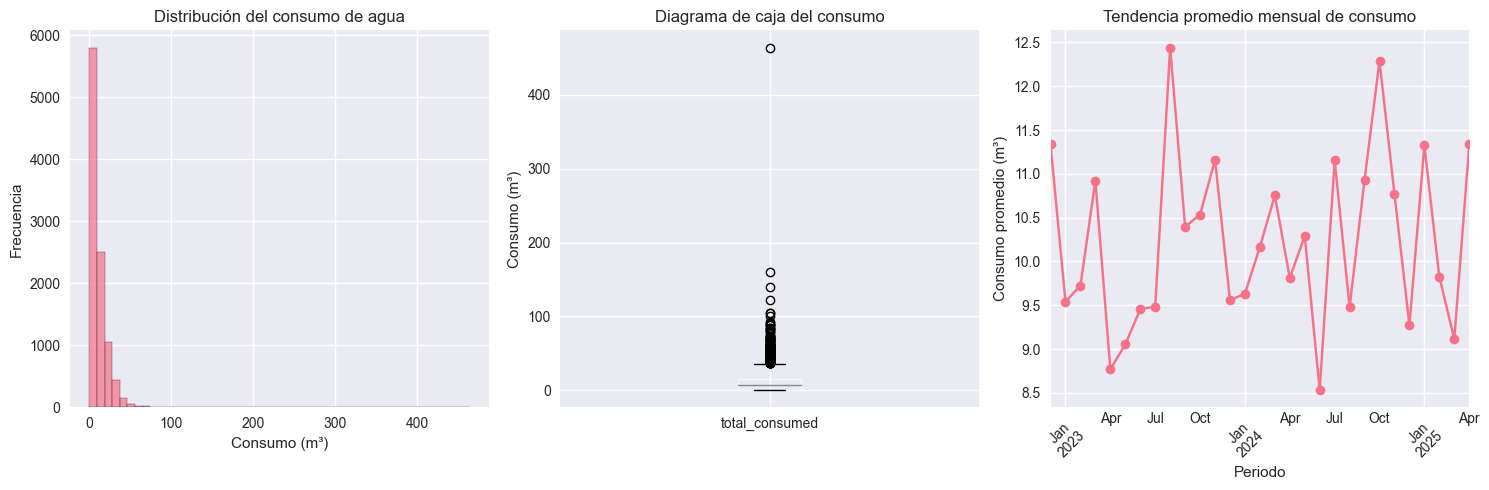

In [7]:
# 2.3 Visualizar la distribución de consumo
measures_df['period_start'] = pd.to_datetime(
    measures_df['period_start'],
    errors='raise'
)

plt.figure(figsize=(15, 5))

# Histograma de consumo
plt.subplot(1, 3, 1)
plt.hist(measures_df['total_consumed'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribución del consumo de agua')
plt.xlabel('Consumo (m³)')
plt.ylabel('Frecuencia')

# Diagrama de caja de consumo
plt.subplot(1, 3, 2)
measures_df.boxplot(column='total_consumed', ax=plt.gca())
plt.title('Diagrama de caja del consumo')
plt.ylabel('Consumo (m³)')

# Tendencia promedio mensual de consumo
plt.subplot(1, 3, 3)
monthly_consumption = measures_df.groupby(
    measures_df['period_start'].dt.to_period('M')
)['total_consumed'].mean()
monthly_consumption.plot(kind='line', marker='o')
plt.title('Tendencia promedio mensual de consumo')
plt.xlabel('Periodo')
plt.ylabel('Consumo promedio (m³)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [9]:
# 3. Procesamiento de datos de precipitación

print("\n🌧️  PROCESANDO DATOS DE PRECIPITACIÓN")
print("-" * 40)

# Inicializar el procesador de precipitación
try:
    rainfall_processor = RainfallProcessor('../data/raw/rainfall_ecuador.csv')
    rainfall_raw = rainfall_processor.load_data()
    print(f"✅ Datos de precipitación cargados: {len(rainfall_raw)} registros")
except Exception as e:
    print(f"❌ Error al cargar datos de precipitación: {e}")
    print("🔄 Por favor asegúrate de que el archivo CSV esté en la ubicación correcta")
    # Crear datos de ejemplo para demostración
    date_range = pd.date_range(start='2021-01-01', end='2023-12-31', freq='D')
    rainfall_raw = pd.DataFrame({
        'date': date_range,
        'adm2_id': 15422,
        'ADM2_PCODE': 'EC0909',
        'n_pixels': np.random.uniform(10, 20, len(date_range)),
        'rfh': np.random.uniform(0, 150, len(date_range)),
        'rfh_avg': np.random.uniform(20, 120, len(date_range)),
        'r1h': np.random.uniform(0, 200, len(date_range)),
        'r1h_avg': np.random.uniform(30, 180, len(date_range)),
        'r3h': np.random.uniform(0, 250, len(date_range)),
        'r3h_avg': np.random.uniform(40, 220, len(date_range))
    })
    rainfall_processor.raw_data = rainfall_raw
    print(f"📝 Datos de precipitación de ejemplo creados: {len(rainfall_raw)} registros")


INFO:utils.data_processing:Loaded rainfall data: 34854 records



🌧️  PROCESANDO DATOS DE PRECIPITACIÓN
----------------------------------------
✅ Datos de precipitación cargados: 34854 registros


In [10]:
# 3.1 Exploración de la estructura de datos de precipitación

print(f"\n📊 VISIÓN GENERAL DE DATOS DE PRECIPITACIÓN:")
print(f"  Rango de fechas: {rainfall_raw['date'].min()} a {rainfall_raw['date'].max()}")
print(f"  Total de días: {len(rainfall_raw)}")

# Mostrar las primeras filas del DataFrame
print(f"\n📋 Muestra de datos de precipitación:")
print(rainfall_raw.head())

# Comprobar valores faltantes en cada columna
missing_data = rainfall_raw.isnull().sum()
print(f"\n🔍 Valores faltantes:")
for col, missing_count in missing_data.items():
    if missing_count > 0:
        print(f"  {col}: {missing_count} ({missing_count/len(rainfall_raw)*100:.1f}%)")



📊 VISIÓN GENERAL DE DATOS DE PRECIPITACIÓN:
  Rango de fechas: 2021-01-01 a 2025-05-01
  Total de días: 34854

📋 Muestra de datos de precipitación:
         date  adm2_id ADM2_PCODE  n_pixels      rfh   rfh_avg       r1h  \
0  2021-01-01    15422     EC0909      14.0  64.7857   73.3476  120.0000   
1  2021-01-11    15422     EC0909      14.0  46.6429   89.6071  151.8571   
2  2021-01-21    15422     EC0909      14.0  69.3571   82.0571  180.7857   
3  2021-02-01    15422     EC0909      14.0  97.2857  122.9452  213.2857   
4  2021-02-11    15422     EC0909      14.0  80.5714  121.5310  247.2143   

    r1h_avg       r3h   r3h_avg      rfq       r1q       r3q version  
0  112.2595  170.0714  147.4262  89.0719  106.3312  114.3847   final  
1  186.7452  214.2857  232.5286  54.5866   82.2674   92.4781   final  
2  245.0119  278.6429  309.7595  85.4119   74.8144   90.2687   final  
3  294.6095  373.2143  428.7286  79.9449   73.3023   87.3466   final  
4  326.5333  450.8571  545.4357  67.628

In [11]:
# 3.2 Limpiar y procesar datos de precipitación

rainfall_clean = rainfall_processor.clean_data()
print("✅ Datos de precipitación limpiados y procesados")

INFO:utils.data_processing:Rainfall data cleaned successfully


✅ Datos de precipitación limpiados y procesados


In [12]:
# 3.3 Agregar datos de precipitación mensualmente

rainfall_monthly = rainfall_processor.aggregate_monthly()
print(f"✅ Agregación mensual completada: {len(rainfall_monthly)} períodos")

print(f"\n📊 ESTADÍSTICAS MENSUALES DE PRECIPITACIÓN:")
print(f"  Períodos: {len(rainfall_monthly)}")
print(f"  Rango de precipitación promedio: {rainfall_monthly['avg_rainfall'].min():.1f} - {rainfall_monthly['avg_rainfall'].max():.1f} mm")
print(f"  Promedio de precipitación mensual: {rainfall_monthly['avg_rainfall'].mean():.1f} mm")

# Mostrar ejemplo de datos mensuales
print(f"\n📋 Ejemplo de datos de precipitación mensual:")
print(rainfall_monthly[['period_str', 'avg_rainfall', 'total_rainfall', 'monthly_intensity']].head(10))


INFO:utils.data_processing:Monthly aggregation completed: 53 periods


✅ Agregación mensual completada: 53 períodos

📊 ESTADÍSTICAS MENSUALES DE PRECIPITACIÓN:
  Períodos: 53
  Rango de precipitación promedio: 16.9 - 86.2 mm
  Promedio de precipitación mensual: 43.4 mm

📋 Ejemplo de datos de precipitación mensual:
  period_str  avg_rainfall  total_rainfall monthly_intensity
0    2021-01     54.716906      36441.4597            Normal
1    2021-02     75.021647      49964.4168               Wet
2    2021-03     86.242920      57437.7850               Wet
3    2021-04     68.109121      45360.6744               Wet
4    2021-05     43.148393      28736.8295            Normal
5    2021-06     30.856227      20550.2472            Normal
6    2021-07     21.984878      14641.9289            Normal
7    2021-08     16.915002      11265.3912               Dry
8    2021-09     19.188264      12779.3841               Dry
9    2021-10     23.568216      15696.4318            Normal


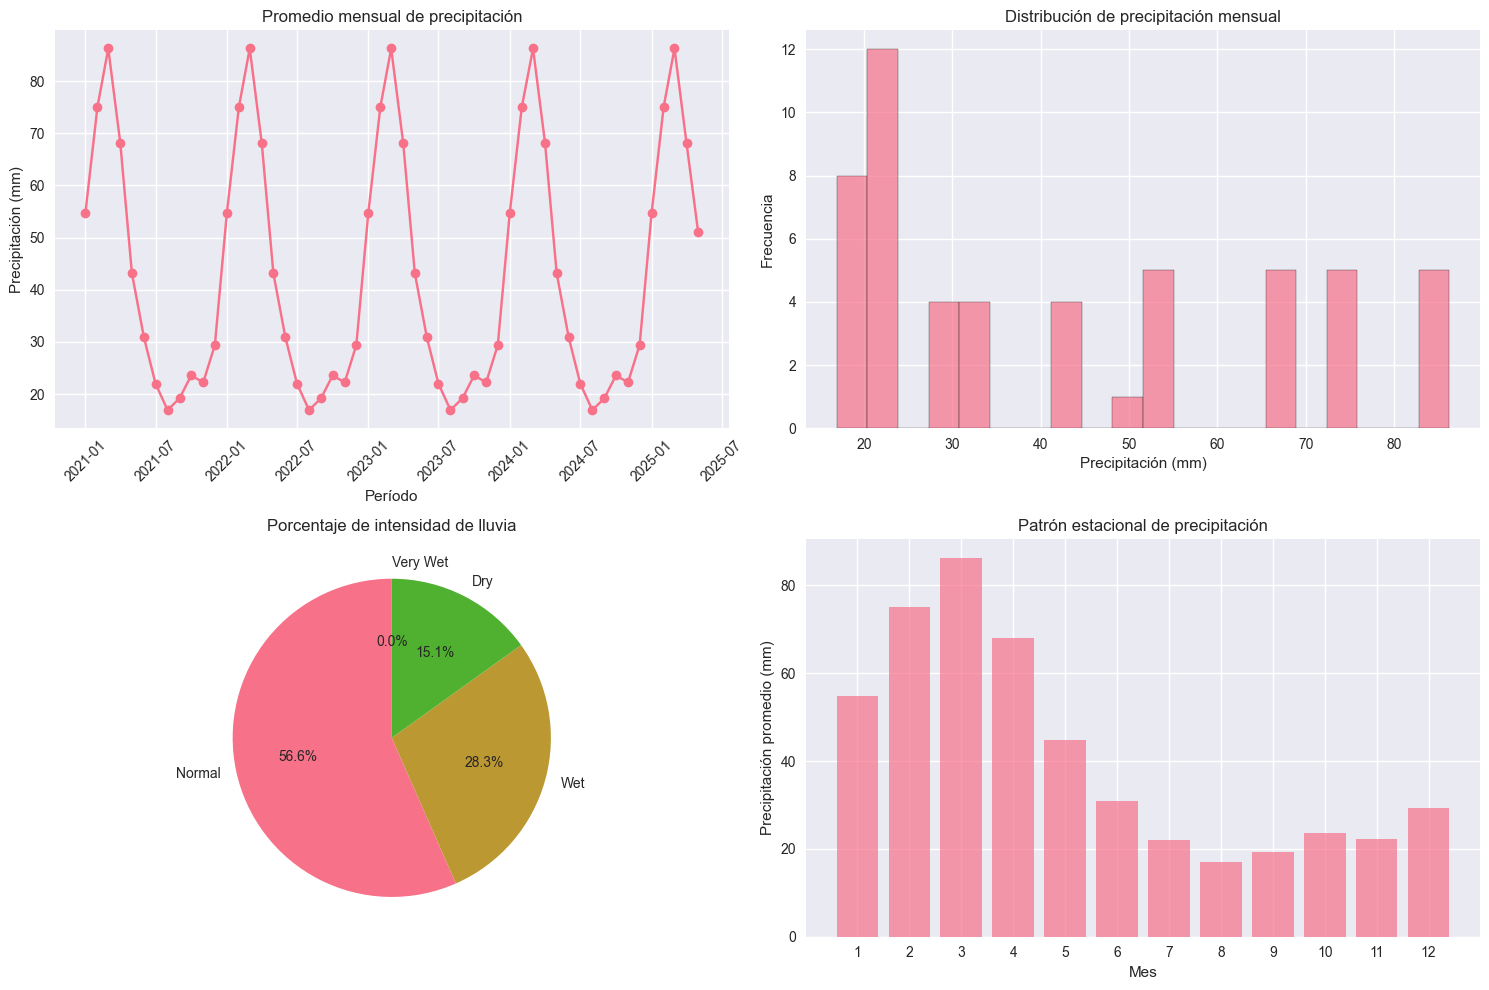

In [13]:
# 3.4 Visualizar patrones de precipitación

plt.figure(figsize=(15, 10))

# 1. Tendencia mensual de precipitación promedio
plt.subplot(2, 2, 1)
plt.plot(pd.to_datetime(rainfall_monthly['period_str']), rainfall_monthly['avg_rainfall'], marker='o')
plt.title('Promedio mensual de precipitación')
plt.xlabel('Período')
plt.ylabel('Precipitación (mm)')
plt.xticks(rotation=45)

# 2. Histograma de precipitación mensual
plt.subplot(2, 2, 2)
rainfall_monthly['avg_rainfall'].hist(bins=20, alpha=0.7, edgecolor='black')
plt.title('Distribución de precipitación mensual')
plt.xlabel('Precipitación (mm)')
plt.ylabel('Frecuencia')

# 3. Distribución de intensidad de lluvia
plt.subplot(2, 2, 3)
intensity_counts = rainfall_monthly['monthly_intensity'].value_counts()
plt.pie(intensity_counts.values,
        labels=intensity_counts.index,
        autopct='%1.1f%%',
        startangle=90)
plt.title('Porcentaje de intensidad de lluvia')

# 4. Patrón estacional de precipitación
plt.subplot(2, 2, 4)
# Extraer mes para agrupar
rainfall_monthly['month'] = pd.to_datetime(rainfall_monthly['period_str']).dt.month
monthly_pattern = rainfall_monthly.groupby('month')['avg_rainfall'].mean()
plt.bar(monthly_pattern.index, monthly_pattern.values, alpha=0.7)
plt.title('Patrón estacional de precipitación')
plt.xlabel('Mes')
plt.ylabel('Precipitación promedio (mm)')
plt.xticks(monthly_pattern.index)

plt.tight_layout()
plt.show()


In [14]:
# 4. Integración y fusión de datos

print("\n🔗 INTEGRACIÓN Y FUSIÓN DE DATOS")
print("-" * 40)

# Inicializar el procesador de datos
data_processor = DataProcessor(db_manager, rainfall_processor)

# Cargar y procesar datos de consumo
consumption_data = data_processor.load_consumption_data()
print(f"✅ Datos de consumo procesados: {len(consumption_data)} registros")

# Agregar el consumo mensualmente
overall_consumption, neighborhood_consumption = data_processor.aggregate_consumption_monthly()
print(f"✅ Consumo mensual agregado: {len(overall_consumption)} períodos")

INFO:utils.data_processing:Loaded consumption data: 10067 records



🔗 INTEGRACIÓN Y FUSIÓN DE DATOS
----------------------------------------
✅ Datos de consumo procesados: 10067 registros


INFO:utils.data_processing:Monthly consumption aggregation completed: 29 periods


✅ Consumo mensual agregado: 29 períodos


In [15]:
# 4.1 Fusión temporal

# Fusionar los datos de precipitación y consumo
merged_data = data_processor.merge_data()
print(f"✅ Fusión de datos completada: {len(merged_data)} períodos coincidentes")

# Mostrar una muestra de los datos fusionados
print("\n📋 EJEMPLO DE DATOS FUSIONADOS:")
cols_mostrar = ['period_str', 'avg_consumption', 'avg_rainfall', 'season', 'consumption_category']
print(merged_data[cols_mostrar].head(10))

INFO:utils.data_processing:Monthly aggregation completed: 53 periods
INFO:utils.data_processing:Monthly consumption aggregation completed: 29 periods
INFO:utils.data_processing:Data merge completed: 29 periods


✅ Fusión de datos completada: 29 períodos coincidentes

📋 EJEMPLO DE DATOS FUSIONADOS:
  period_str  avg_consumption  avg_rainfall        season consumption_category
0    2022-12        11.338150     29.381542    Dry Season                 High
1    2023-01         9.540462     54.716906    Dry Season                  Low
2    2023-02         9.724138     75.021647    Dry Season               Medium
3    2023-03        10.921965     86.242920    Dry Season                 High
4    2023-04         8.768786     68.109121  Rainy Season                  Low
5    2023-05         9.052023     43.148393  Rainy Season                  Low
6    2023-06         9.455072     30.856227  Rainy Season                  Low
7    2023-07         9.485465     21.984878  Rainy Season                  Low
8    2023-08        12.441860     16.915002  Rainy Season                 High
9    2023-09        10.395349     19.188264  Rainy Season               Medium


In [18]:
# 4.2 Evaluación de la calidad de la fusión de datos
print(f"\n📊 MÉTRICAS DE CALIDAD DE FUSIÓN:")
print(f"  Períodos originales de consumo: {len(overall_consumption)}")
print(f"  Períodos originales de precipitación: {len(rainfall_monthly)}")
print(f"  Períodos fusionados exitosamente: {len(merged_data)}")
print(f"  Tasa de éxito de la fusión: {len(merged_data)/max(len(overall_consumption), len(rainfall_monthly))*100:.1f}%")

# Verificar huecos en los datos
print("\n🔍 VERIFICANDO HUECOS EN LOS DATOS:")

# Determinar columna de período en overall_consumption
if 'period_str' in overall_consumption.columns:
    consumption_periods = set(overall_consumption['period_str'])
    consumption_col = 'period_str'
elif 'period' in overall_consumption.columns:
    consumption_periods = set(overall_consumption['period'])
    consumption_col = 'period'
else:
    period_like_cols = [col for col in overall_consumption.columns if 'period' in col.lower()]
    if period_like_cols:
        consumption_col = period_like_cols[0]
        consumption_periods = set(overall_consumption[consumption_col])
        print(f"  Usando columna '{consumption_col}' para períodos de consumo")
    else:
        print("  ❌ No se encontró columna de período en datos de consumo")
        consumption_periods = set()

# Determinar columna de período en rainfall_monthly
if 'period_str' in rainfall_monthly.columns:
    rainfall_periods = set(rainfall_monthly['period_str'])
elif 'period' in rainfall_monthly.columns:
    rainfall_periods = set(rainfall_monthly['period'])
else:
    print("  ❌ No se encontró columna de período en datos de precipitación")
    rainfall_periods = set()

# Determinar columna de período en merged_data
if 'period_str' in merged_data.columns:
    merged_periods = set(merged_data['period_str'])
elif 'period' in merged_data.columns:
    merged_periods = set(merged_data['period'])
else:
    print("  ❌ No se encontró columna de período en datos fusionados")
    merged_periods = set()

# Calcular diferencias y solapamientos
if consumption_periods and rainfall_periods:
    missing_consumption = consumption_periods - rainfall_periods
    missing_rainfall = rainfall_periods - consumption_periods

    if missing_consumption:
        print(f"  Períodos de consumo sin precipitación: {len(missing_consumption)}")
        if len(missing_consumption) <= 5:
            print(f"    Ejemplos: {list(missing_consumption)[:5]}")
    else:
        print("  ✅ Todos los períodos de consumo tienen datos de precipitación")

    if missing_rainfall:
        print(f"  Períodos de precipitación sin consumo: {len(missing_rainfall)}")
        if len(missing_rainfall) <= 5:
            print(f"    Ejemplos: {list(missing_rainfall)[:5]}")
    else:
        print("  ✅ Todos los períodos de precipitación tienen datos de consumo")
        
    overlap = consumption_periods & rainfall_periods
    print(f"  Períodos comunes: {len(overlap)}")
    print(f"  Solapamiento de datos: {len(overlap)/max(len(consumption_periods), len(rainfall_periods))*100:.1f}%")

else:
    print("  ⚠️ No se pueden analizar huecos de datos – revisar columnas disponibles...")



📊 MÉTRICAS DE CALIDAD DE FUSIÓN:
  Períodos originales de consumo: 29
  Períodos originales de precipitación: 53
  Períodos fusionados exitosamente: 29
  Tasa de éxito de la fusión: 54.7%

🔍 VERIFICANDO HUECOS EN LOS DATOS:
  ✅ Todos los períodos de consumo tienen datos de precipitación
  Períodos de precipitación sin consumo: 24
  Períodos comunes: 29
  Solapamiento de datos: 54.7%


In [22]:
# 4.3 Calcular correlación entre lluvia y consumo

correlation = merged_data['avg_consumption'].corr(merged_data['avg_rainfall'])
print("\n📈 ANÁLISIS DE CORRELACIÓN:")

# Determinar la fuerza de la correlación
if abs(correlation) < 0.1:
    correlation_strength = "Muy débil"
elif abs(correlation) < 0.3:
    correlation_strength = "Débil"
elif abs(correlation) < 0.5:
    correlation_strength = "Moderada"
elif abs(correlation) < 0.7:
    correlation_strength = "Fuerte"
else:
    correlation_strength = "Muy fuerte"

# Determinar la dirección de la correlación
print(f"🔍 Correlación lluvia–consumo: {correlation:.3f}. Esto indica una relación débil y negativa: a mayor precipitación, el consumo de agua tiende a disminuir ligeramente, pero la lluvia explica solo alrededor del {abs(correlation)**2*100:.1f}% de la variabilidad del consumo.")


📈 ANÁLISIS DE CORRELACIÓN:
🔍 Correlación lluvia–consumo: -0.220. Esto indica una relación débil y negativa: a mayor precipitación, el consumo de agua tiende a disminuir ligeramente, pero la lluvia explica solo alrededor del 4.8% de la variabilidad del consumo.


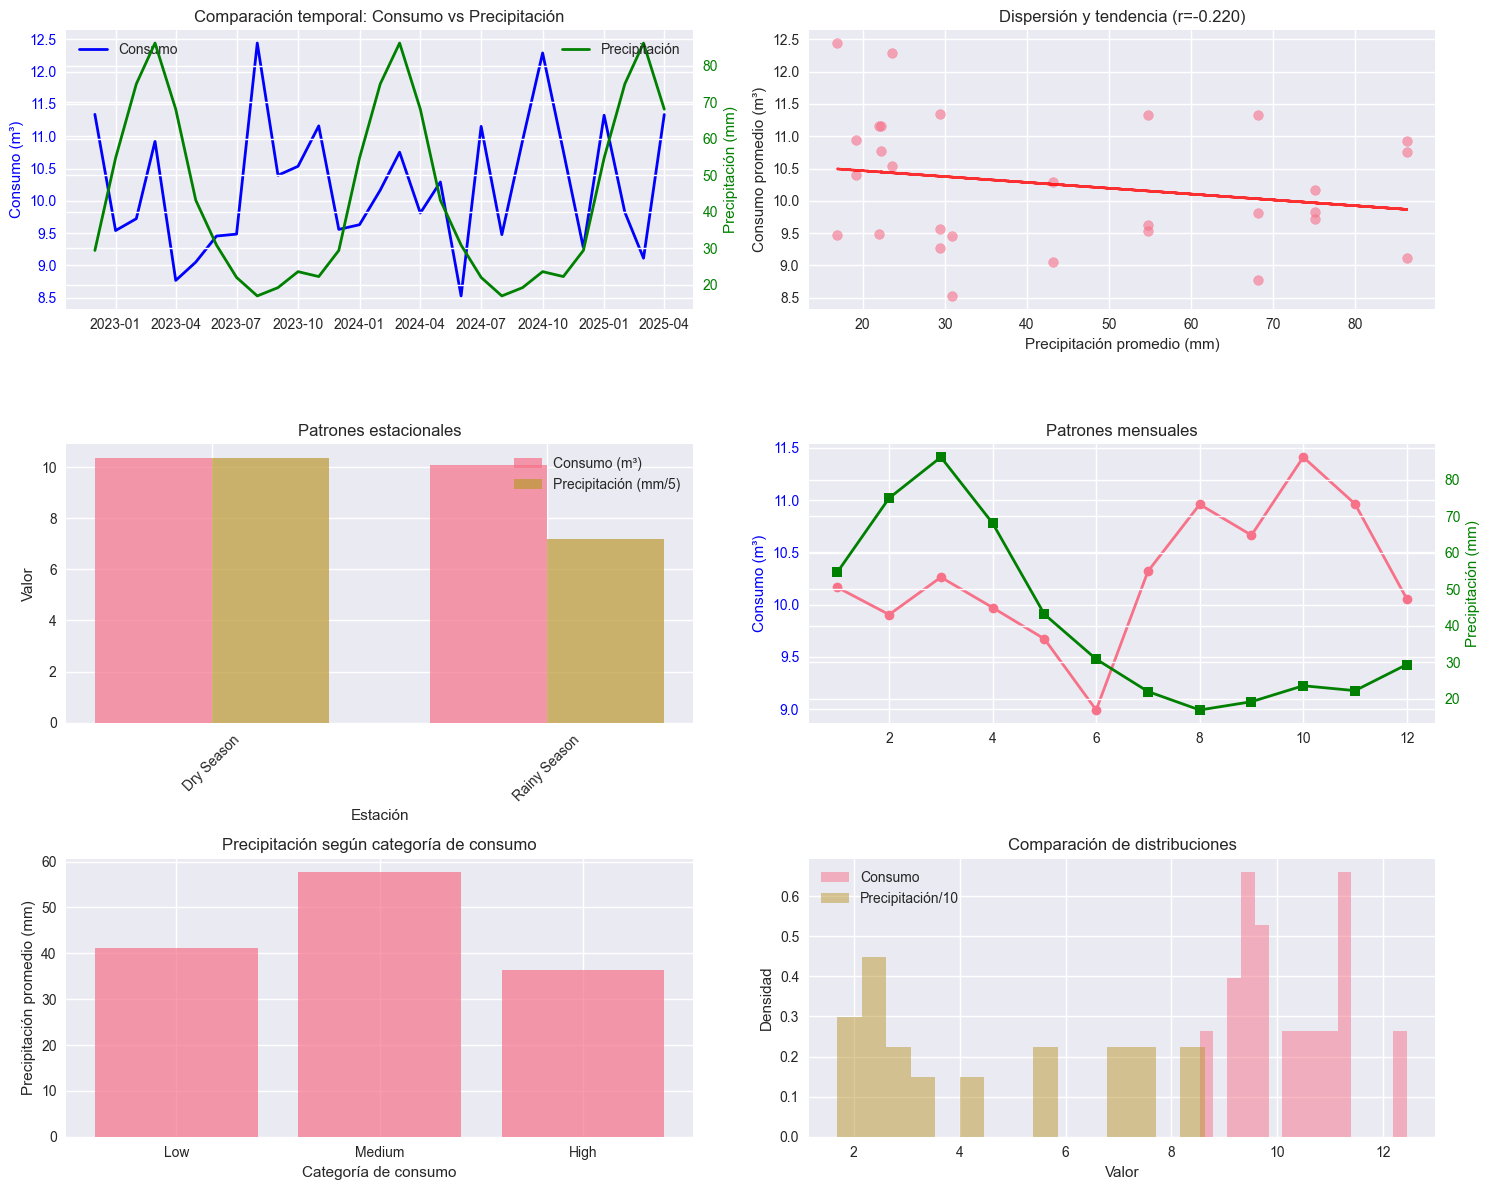

In [23]:
# 4.4 Visualizar datos fusionados

plt.figure(figsize=(15, 12))

# 1. Comparación temporal: Consumo vs Precipitación
plt.subplot(3, 2, 1)
plt.plot(merged_data['period_dt'], merged_data['avg_consumption'], 'b-', label='Consumo', linewidth=2)
plt.ylabel('Consumo (m³)', color='b')
plt.tick_params(axis='y', labelcolor='b')
plt.legend(loc='upper left')

ax2 = plt.gca().twinx()
ax2.plot(merged_data['period_dt'], merged_data['avg_rainfall'], 'g-', label='Precipitación', linewidth=2)
ax2.set_ylabel('Precipitación (mm)', color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.legend(loc='upper right')
plt.title('Comparación temporal: Consumo vs Precipitación')
plt.xticks(rotation=45)

# 2. Gráfico de dispersión de correlación
plt.subplot(3, 2, 2)
plt.scatter(merged_data['avg_rainfall'], merged_data['avg_consumption'], alpha=0.6, s=50)
z = np.polyfit(merged_data['avg_rainfall'], merged_data['avg_consumption'], 1)
p = np.poly1d(z)
plt.plot(merged_data['avg_rainfall'], p(merged_data['avg_rainfall']), "r--", alpha=0.8)
plt.xlabel('Precipitación promedio (mm)')
plt.ylabel('Consumo promedio (m³)')
plt.title(f'Dispersión y tendencia (r={correlation:.3f})')

# 3. Patrones estacionales
plt.subplot(3, 2, 3)
seasonal_data = merged_data.groupby('season')[['avg_consumption', 'avg_rainfall']].mean()
x = np.arange(len(seasonal_data.index))
width = 0.35
plt.bar(x - width/2, seasonal_data['avg_consumption'], width, label='Consumo (m³)', alpha=0.7)
plt.bar(x + width/2, seasonal_data['avg_rainfall']/5, width, label='Precipitación (mm/5)', alpha=0.7)
plt.xlabel('Estación')
plt.ylabel('Valor')
plt.title('Patrones estacionales')
plt.xticks(x, seasonal_data.index, rotation=45)
plt.legend()

# 4. Tendencias mensuales
plt.subplot(3, 2, 4)
monthly_trends = merged_data.groupby('month')[['avg_consumption', 'avg_rainfall']].mean()
plt.plot(monthly_trends.index, monthly_trends['avg_consumption'], 'o-', label='Consumo', linewidth=2)
plt.ylabel('Consumo (m³)', color='b')
plt.tick_params(axis='y', labelcolor='b')

ax3 = plt.gca().twinx()
ax3.plot(monthly_trends.index, monthly_trends['avg_rainfall'], 's-', color='green', label='Precipitación', linewidth=2)
ax3.set_ylabel('Precipitación (mm)', color='g')
ax3.tick_params(axis='y', labelcolor='g')
plt.title('Patrones mensuales')
plt.xlabel('Mes')

# 5. Precipitación según categoría de consumo
plt.subplot(3, 2, 5)
category_rainfall = merged_data.groupby('consumption_category')['avg_rainfall'].mean()
plt.bar(category_rainfall.index, category_rainfall.values, alpha=0.7)
plt.xlabel('Categoría de consumo')
plt.ylabel('Precipitación promedio (mm)')
plt.title('Precipitación según categoría de consumo')

# 6. Comparación de distribuciones
plt.subplot(3, 2, 6)
plt.hist(merged_data['avg_consumption'], bins=15, alpha=0.5, label='Consumo', density=True)
plt.hist(merged_data['avg_rainfall']/10, bins=15, alpha=0.5, label='Precipitación/10', density=True)
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.title('Comparación de distribuciones')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# 5. Características

print("\n⚙️  CARACTERÍSTICAS")
print("-" * 40)

# Crear características para ML
ml_features = data_processor.create_features_for_ml()
print(f"✅ Características para ML creadas: {ml_features.shape[1]} características")

# Lista de características clave a verificar
feature_list = [
    'avg_consumption', 'avg_rainfall', 'consumption_ma_3', 'rainfall_ma_3',
    'month_sin', 'month_cos', 'rainfall_season_interaction', 'consumption_zscore',
    'rainfall_zscore', 'rainfall_consumption_ratio', 'consumption_efficiency'
]

print(f"\n📊 CARACTERÍSTICAS CLAVE CREADAS:")
for feature in feature_list:
    if feature in ml_features.columns:
        print(f"  ✅ {feature}")
    else:
        print(f"  ❌ {feature} (no encontrada)")

# Mostrar estadísticas de las características
print(f"\n📋 ESTADÍSTICAS DE LAS CARACTERÍSTICAS:")
feature_stats = ml_features[feature_list].describe()
print(feature_stats.round(3))


INFO:utils.data_processing:ML features created successfully



⚙️  CARACTERÍSTICAS
----------------------------------------
✅ Características para ML creadas: 63 características

📊 CARACTERÍSTICAS CLAVE CREADAS:
  ✅ avg_consumption
  ✅ avg_rainfall
  ✅ consumption_ma_3
  ✅ rainfall_ma_3
  ✅ month_sin
  ✅ month_cos
  ✅ rainfall_season_interaction
  ✅ consumption_zscore
  ✅ rainfall_zscore
  ✅ rainfall_consumption_ratio
  ✅ consumption_efficiency

📋 ESTADÍSTICAS DE LAS CARACTERÍSTICAS:
       avg_consumption  avg_rainfall  consumption_ma_3  rainfall_ma_3  \
count           29.000        29.000            29.000         29.000   
mean            10.243        44.696            10.211         44.493   
std              1.006        24.461             0.510         20.940   
min              8.529        16.915             9.092         19.363   
25%              9.485        22.224             9.991         23.252   
50%             10.166        30.856            10.201         47.371   
75%             10.934        68.109            10.461        

In [25]:
# 6. Evaluación de calidad de datos

print("\n🔍 EVALUACIÓN DE CALIDAD DE DATOS")
print("-" * 40)

# Valores faltantes en el conjunto final
missing_ml = ml_features.isnull().sum()
total_missing = missing_ml.sum()
print(f"📊 Total de valores faltantes en el conjunto ML: {total_missing}")

if total_missing > 0:
    print("Valores faltantes por característica:")
    for feature, missing in missing_ml.items():
        if missing > 0:
            print(f"  {feature}: {missing} ({missing/len(ml_features)*100:.1f}%)")

# Detección de valores atípicos
print(f"\n📊 DETECCIÓN DE OUTLIERS:")
outlier_features = ['avg_consumption', 'avg_rainfall']
for feature in outlier_features:
    Q1 = ml_features[feature].quantile(0.25)
    Q3 = ml_features[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = ml_features[(ml_features[feature] < lower_bound) | 
                           (ml_features[feature] > upper_bound)]
    print(f"  {feature}: {len(outliers)} outliers ({len(outliers)/len(ml_features)*100:.1f}%)")



🔍 EVALUACIÓN DE CALIDAD DE DATOS
----------------------------------------
📊 Total de valores faltantes en el conjunto ML: 0

📊 DETECCIÓN DE OUTLIERS:
  avg_consumption: 0 outliers (0.0%)
  avg_rainfall: 0 outliers (0.0%)


In [26]:
# 7. Estadísticas Resumidas

print("\n📊 ESTADÍSTICAS RESUMIDAS")
print("-" * 40)

summary_stats = data_processor.get_summary_statistics()

# Visión general del dataset
print("📈 VISIÓN GENERAL DEL CONJUNTO DE DATOS:")
print(f"  Total de períodos analizados: {summary_stats['total_periods']}")
print(f"  Rango de fechas: {summary_stats['date_range']['start']} a {summary_stats['date_range']['end']}")

# Insights de consumo
print("\n💧 INSIGHTS DE CONSUMO:")
cons_stats = summary_stats['consumption_stats']
cv_consumption = cons_stats['std'] / cons_stats['mean'] * 100
print(f"  Consumo mensual promedio: {cons_stats['mean']:.1f} m³")
print(f"  Variabilidad (CV): {cv_consumption:.1f}%")
print(f"  Rango: {cons_stats['min']:.1f} – {cons_stats['max']:.1f} m³")

# Insights de precipitación
print("\n🌧️  INSIGHTS DE PRECIPITACIÓN:")
rain_stats = summary_stats['rainfall_stats']
cv_rainfall = rain_stats['std'] / rain_stats['mean'] * 100
print(f"  Precipitación mensual promedio: {rain_stats['mean']:.1f} mm")
print(f"  Variabilidad (CV): {cv_rainfall:.1f}%")
print(f"  Rango: {rain_stats['min']:.1f} – {rain_stats['max']:.1f} mm")

# Insights de relación
print("\n🔗 INSIGHTS DE RELACIÓN:")
corr = summary_stats['correlation']['rainfall_consumption']
print(f"  Correlación lluvia–consumo: {corr:.3f}")
if corr < -0.3:
    interp = "Relación inversa fuerte (más lluvia → menos consumo)"
elif corr > 0.3:
    interp = "Relación positiva fuerte (más lluvia → más consumo)"
else:
    interp = "Relación débil entre lluvia y consumo"
print(f"  Interpretación: {interp}")

# Insights estacionales
print("\n🗓️  INSIGHTS ESTACIONALES:")
seasons = summary_stats['seasonal_patterns']
print("  Consumo promedio:")
print(f"    Temporada seca: {seasons['avg_consumption'].get('Dry Season'):.1f} m³")
print(f"    Temporada lluviosa: {seasons['avg_consumption'].get('Rainy Season'):.1f} m³")
print("  Precipitación promedio:")
print(f"    Temporada seca: {seasons['avg_rainfall'].get('Dry Season'):.1f} mm")
print(f"    Temporada lluviosa: {seasons['avg_rainfall'].get('Rainy Season'):.1f} mm")



📊 ESTADÍSTICAS RESUMIDAS
----------------------------------------
📈 VISIÓN GENERAL DEL CONJUNTO DE DATOS:
  Total de períodos analizados: 29
  Rango de fechas: 2022-12 a 2025-04

💧 INSIGHTS DE CONSUMO:
  Consumo mensual promedio: 10.2 m³
  Variabilidad (CV): 9.8%
  Rango: 8.5 – 12.4 m³

🌧️  INSIGHTS DE PRECIPITACIÓN:
  Precipitación mensual promedio: 44.7 mm
  Variabilidad (CV): 54.7%
  Rango: 16.9 – 86.2 mm

🔗 INSIGHTS DE RELACIÓN:
  Correlación lluvia–consumo: -0.220
  Interpretación: Relación débil entre lluvia y consumo

🗓️  INSIGHTS ESTACIONALES:
  Consumo promedio:
    Temporada seca: 10.4 m³
    Temporada lluviosa: 10.1 m³
  Precipitación promedio:
    Temporada seca: 51.7 mm
    Temporada lluviosa: 36.0 mm


In [27]:
# 8. Guardar datos procesados

print("\n💾 GUARDANDO DATOS PROCESADOS")
print("-" * 40)
save_path = "../data/processed/"

try:
    data_processor.save_processed_data(save_path)
    print(f"✅ Todos los datos procesados guardados en: {save_path}")
    
    # Listar archivos guardados
    import os
    saved_files = os.listdir(save_path)
    print("📁 Archivos guardados:")
    for file in saved_files:
        file_path = os.path.join(save_path, file)
        file_size = os.path.getsize(file_path) / 1024  # KB
        print(f"  • {file} ({file_size:.1f} KB)")
        
except Exception as e:
    print(f"❌ Error al guardar los datos: {e}")


INFO:utils.data_processing:ML features created successfully
INFO:utils.data_processing:Processed data saved to ../data/processed



💾 GUARDANDO DATOS PROCESADOS
----------------------------------------
✅ Todos los datos procesados guardados en: ../data/processed/
📁 Archivos guardados:
  • merged_rainfall_consumption.csv (20.0 KB)
  • summary_statistics.json (0.7 KB)
  • ml_features.csv (23.9 KB)
  • individual_consumption.csv (1854.7 KB)


In [28]:
# Cerrar la conexión a la base de datos
db_manager.close()
print("\n🔐 Conexión a la base de datos cerrada")
print("="*60)
print("¡INTEGRACIÓN DE DATOS COMPLETADA CON ÉXITO!")
print("="*60)

INFO:database.connection:Database connection closed



🔐 Conexión a la base de datos cerrada
¡INTEGRACIÓN DE DATOS COMPLETADA CON ÉXITO! 🎉
